In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
import multiprocessing as mp
from scipy.stats import beta
import matplotlib as mpl
from numba import njit
import itertools
from strategy_name import strategy_name
import pickle
from theory_functions import avg_prob_adoption,get_group_pdfs


%matplotlib inline

In [2]:
print(mp.cpu_count())
p = mp.Pool(processes=mp.cpu_count())

16


In [32]:
@njit(fastmath=True)
def gaussian(x, mu, sig):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))/(sig*(2*np.pi)**0.5)
@njit(fastmath=True)
def bimodal(x,frac,mu1,sig1,mu2,sig2):
    return frac*gaussian(x,mu1,sig1)+(1-frac)*gaussian(x,mu2,sig2)
@njit(fastmath=True)
def powerlaw(x, gamma):
    return np.power(x,-gamma)


In [33]:
# Define the system of ODEs
@njit(fastmath=True)
def intervention_dynamics(x, t,gamma_list,t_gamma_pdf,nt_gamma_pdf,k_list,t_k_pdf,nt_k_pdf,phi,w):
    
    x_t, x_nt = x
        
    # Compute average degrees (the degree distributions are normalized)
    avg_deg_target = np.sum(k_list * t_k_pdf)
    avg_deg_non_target = np.sum(k_list * nt_k_pdf)
    
    # Compute the overall probability that a randomly chosen link goes to an adopter.
    denominator = phi * avg_deg_target + (1 - phi) * avg_deg_non_target
    if denominator == 0:
        p_link = 0.0
    else:
        p_link = (avg_deg_target * x_t +  avg_deg_non_target * x_nt) / denominator
    
    
    dxdt = avg_prob_adoption(t_k_pdf,k_list,t_gamma_pdf,gamma_list,p_link,w)*phi-x_t
    dydt = avg_prob_adoption(nt_k_pdf,k_list,nt_gamma_pdf,gamma_list,p_link,w)*(1-phi) -x_nt
   
     
    
    return [dxdt, dydt]


def trajectory(strategy,gamma_list, gamma_pdf,k_list,k_pdf,phi,w,num_of_iter,multiplier):
    
    if strategy in {10,11}:
        
        # Compute the gamma distributions for target and non-target groups.
        
        t_gamma_pdf, nt_gamma_pdf =get_group_pdfs(gamma_list, gamma_pdf, phi, strategy%10)
        t_k_pdf=k_pdf
        nt_k_pdf=k_pdf
        #incentive_cost=(-np.sum(gamma_list * t_gamma_pdf)*phi+np.sum(k_list * t_k_pdf)*w+1)
    elif strategy in {20,21}:
                
        # Compute the degree distributions for target and non-target groups.
        
        t_k_pdf, nt_k_pdf = get_group_pdfs(k_list, k_pdf, phi, strategy%10)
        t_gamma_pdf=gamma_pdf
        nt_gamma_pdf=gamma_pdf
        #incentive_cost=(-np.sum(gamma_list * t_gamma_pdf)+np.sum(k_list * t_k_pdf)*w*phi+1)
    else:
        t_k_pdf=k_pdf
        nt_k_pdf=k_pdf
        t_gamma_pdf=gamma_pdf
        nt_gamma_pdf=gamma_pdf
        #incentive_cost=(-np.sum(gamma_list * t_gamma_pdf)*phi+np.sum(k_list * t_k_pdf)*w*phi+1)
    
    incentive_cost=(-np.sum(gamma_list * t_gamma_pdf)+np.sum(k_list * t_k_pdf)*w+1)*phi
    t=np.linspace(0,num_of_iter,multiplier*num_of_iter)
    x0=[phi,0]
    
        
    sol = np.array(odeint(intervention_dynamics, x0, t,args=(gamma_list,t_gamma_pdf,nt_gamma_pdf,k_list,t_k_pdf,nt_k_pdf,phi,w)))
    
    x_t= sol[:,0]/phi 
    x_nt= sol[:,1]/(1-phi)   
    
    final_adoption=sol[-1,0]+sol[-1,1]
    return x_t,x_nt,final_adoption,incentive_cost

In [34]:
st = time.time()

#strategy_type=0 for random, 11 for resistant, 10 for amenable, 20 for high degree,21 for low degree
strategy_list=[0,11,10,20,21]

strategy=10 # amenable

strategy_string=strategy_name(strategy)

param_spacing=51

w=0.5

alpha=2

phi_list=np.linspace(0.01,0.99,param_spacing)
V=5

z=10

# k_list=np.array(list(range(1, 50)))
# k_pdf=np.array([gaussian(x,int(z*2),5.5) for x in k_list])
k_list = np.array(list(range(z, 150)))
k_pdf=np.array([powerlaw(x,2.99) for x in k_list])
norm=sum(k_pdf)
k_pdf=k_pdf/norm

mu=0.2
gamma_list=np.linspace(mu-0.499,mu+0.499, 50)
gamma_pdf = beta.pdf(gamma_list-(mu-0.5), alpha, alpha)  


gamma_pdf=gamma_pdf/sum(gamma_pdf)
gamma_list=gamma_list*V

num_of_iter=15
multiplier=25

input_list=np.array([(strategy,gamma_list, gamma_pdf,k_list,k_pdf,phi,w,num_of_iter,multiplier) for phi in phi_list], dtype=object)    
x_t,x_nt,final_adoption,incentive_cost=zip(*p.starmap(trajectory, input_list))

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 23.02041268348694 seconds


In [35]:
x_t=np.array(x_t)
x_t.shape=(param_spacing,num_of_iter*multiplier)

x_nt=np.array(x_nt)
x_nt.shape=(param_spacing,num_of_iter*multiplier)
final_adoption=np.array(final_adoption)
incentive_cost=np.array(incentive_cost)

    

Minimum intervention size = 0.4
Minimum intervention cost = 3.16


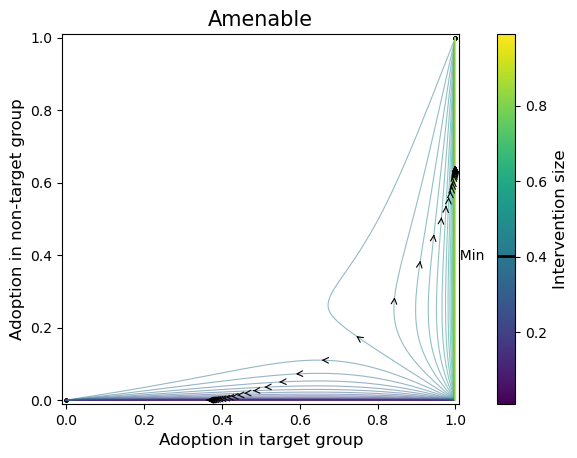

In [36]:

x_series=[x_t[i]*phi_list[i]+x_nt[i]*(1-phi_list[i]) for i in range(len(phi_list))]
#plt.figure(figsize=(8, 6))
#plt.quiver(X, Y, U, V, color="blue", alpha=0.8, pivot="middle", scale=20)
fig,ax=plt.subplots()
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min(phi_list), vmax=max(phi_list))  # Normalize color mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessary for the color bar




for i,phi in enumerate(phi_list):


    ax.plot(x_t[i], x_nt[i],color=cmap((phi-min(phi_list)/(max(phi_list)-min(phi_list)))),alpha=0.5,linewidth=0.8)
    ax.scatter(x_t[i,-1],x_nt[i,-1],color='k',alpha=0.5,s=3)

    mid_idx = len(x_t[i]) // int(num_of_iter/1)  # Find the midpoint index
    dx = x_t[i,mid_idx + 1] - x_t[i,mid_idx]
    dy = x_nt[i,mid_idx + 1] - x_nt[i,mid_idx]
    ax.annotate(
        "",
        xy=(x_t[i,mid_idx] + dx, x_nt[i,mid_idx] + dy),
        xytext=(x_t[i,mid_idx], x_nt[i,mid_idx]),
        arrowprops=dict(arrowstyle="->", color='k', lw=0.8,alpha=1),
    )



ax.set_xlabel("Adoption in target group",fontsize=12)
ax.set_ylabel("Adoption in non-target group",fontsize=12)
ax.set_title(strategy_string,fontsize=15)
ax.set_xlim([-0.01,1.01])
ax.set_ylim([-0.01,1.01])

# Add the color bar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Intervention size",fontsize=12)  
         

for i,phi in enumerate(phi_list):
    if final_adoption[i]>0.95:
        min_phi=phi
        cost=incentive_cost[i]

        break

print('Minimum intervention size = '+str(round(min_phi,2)))
print('Minimum intervention cost = '+str(round(cost,2)))
cbar.ax.axhline(min_phi, color='k', linestyle='-', linewidth=2)
# Add a text label next to the line.
cbar.ax.text(-2.5, min_phi, '  Min', va='center', ha='left', color='k', fontsize=10,
             transform=cbar.ax.transData)   
pos = cbar.ax.get_position()
cbar.ax.set_position([pos.x0 + 0.02, pos.y0, pos.width, pos.height])

Text(0.5, 1.0, 'Amenable, phi = 0.4')

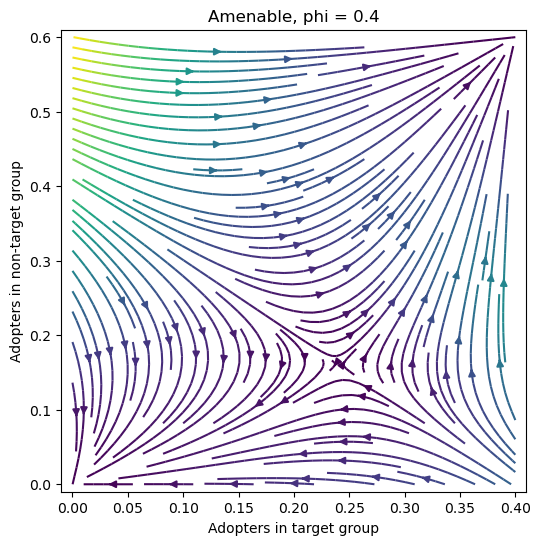

In [28]:
strategy=10
strategy_string=strategy_name(strategy)

phi=0.4


spacing=25
x_t=np.linspace(0,phi,spacing)
x_nt=np.linspace(0,(1-phi),spacing)



X, Y = np.meshgrid(x_t, x_nt)


U=np.zeros_like(X)
V=np.zeros_like(X)


if strategy in {10,11}:

    # Compute the gamma distributions for target and non-target groups.

    t_gamma_pdf, nt_gamma_pdf =get_group_pdfs(gamma_list, gamma_pdf, phi, strategy%10)
    t_k_pdf=k_pdf
    nt_k_pdf=k_pdf
    #incentive_cost=(-np.sum(gamma_list * t_gamma_pdf)*phi+np.sum(k_list * t_k_pdf)*w+1)
elif strategy in {20,21}:

    # Compute the degree distributions for target and non-target groups.

    t_k_pdf, nt_k_pdf = get_group_pdfs(k_list, k_pdf, phi, strategy%10)
    t_gamma_pdf=gamma_pdf
    nt_gamma_pdf=gamma_pdf
    #incentive_cost=(-np.sum(gamma_list * t_gamma_pdf)+np.sum(k_list * t_k_pdf)*w*phi+1)
else:
    t_k_pdf=k_pdf
    nt_k_pdf=k_pdf
    t_gamma_pdf=gamma_pdf
    nt_gamma_pdf=gamma_pdf

input_list=np.array([([X[i,j],Y[i,j]],0, gamma_list,t_gamma_pdf,nt_gamma_pdf,k_list,t_k_pdf,nt_k_pdf,phi,w) for i ,j in itertools.product(range(spacing),range(spacing))], dtype=object)
UV=p.starmap(intervention_dynamics, input_list)

UV=np.array(UV)
UV.shape=(spacing,spacing,2)
U=UV[:,:,0]
V=UV[:,:,1]

# U=U/phi
# X=X/phi
# V=V/(1-phi)
# Y=Y/(1-phi)

fig, ax = plt.subplots(figsize=(6,6))
ax.streamplot(X, Y, U, V, density=1.5,cmap ='viridis',color=U**2+V**2)
ax.set_xlabel("Adopters in target group")
ax.set_ylabel("Adopters in non-target group")
ax.set_xlim([-0.01,phi+0.01])
ax.set_ylim([-0.01,1.01-phi])

ax.set_title(strategy_string+', phi = '+str(round(phi,2)))
            